In [1]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from scipy.stats import pearsonr
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

In [ ]:
p_nw = []
p_net_nw = []
loss_nw = []
loss_net_nw = []
bool_nw = []

for network_name in ["Random_ER", "Random_SF", "ChIP_hTFtarget", "ChIP_TIP", "ChIP_TIP_K562", "CoExpr_perturb_0.5", "CoExpr_GTEx_WholeBlood_0.75", "CoExpr_ENCODE_K562_0.75", "BIOGRID", "STRING", "Combine", "NOTEARS_thresholdAdaptive", "DAGMA_thresholdAdaptive"]:
    
    # measurements across 10 random sample split
    p_rs = []
    p_net_rs = []
    loss_rs = []
    loss_net_rs = []
    bool_rs = []
    
    for rs in range(10):
        # read data
        X_train = pd.read_csv("../../result/input_perturb_phyloP/%d/X_train_stratified" % rs, sep="\t", index_col=0).values
        X_valid = pd.read_csv("../../result/input_perturb_phyloP/%d/X_valid_stratified" % rs, sep="\t", index_col=0).values
        X_test = pd.read_csv("../../result/input_perturb_phyloP/%d/X_test_stratified" % rs, sep="\t", index_col=0).values
        Y_test = pd.read_csv("../../result/input_perturb_phyloP/%d/Y_test_stratified" % rs, sep="\t", index_col=0).values.reshape(-1)
        Y_test_gene = pd.read_csv("../../result/input_perturb_phyloP/%d/Y_test_stratified" % rs, sep="\t", index_col=0).index

        test_mask = np.concatenate([[False] * len(X_train), [False] * len(X_valid), [True] * len(X_test)])

        # mask of whether a test node is in the DAGMA graph
        dag = pd.read_csv("../../result/network_perturb_phyloP/DAGMA_thresholdAdaptive.tsv", sep="\t", header=None)
        id2genes = pd.read_csv("../../result/network_perturb_phyloP/valid_genes", sep="\t").set_index("ID")['genes'].to_dict()
        dag[0] = dag[0].map(id2genes)
        dag[1] = dag[1].map(id2genes)
        dag_genes = list(set.union(set(dag[0]), set(dag[1])))
        test_inDAG = Y_test_gene.isin(dag_genes)

        # measurements across 10 random init repeats
        p_rep = []
        p_net_rep = []
        loss_rep = []
        loss_net_rep = []

        for rep in range(10):
            prefix = "../../result/model_perturb_phyloP_SGC/%s/%d/model%d" % (network_name, rs, rep)
            with open(prefix+".para", "rb") as f:
                best_params, X1, out, loss1, loss2 = pickle.load(f)
            Y_pred = out[test_mask].reshape(-1)

            loss_rep.append(F.mse_loss(torch.tensor(Y_test), torch.tensor(Y_pred)).item())
            loss_net_rep.append(F.mse_loss(torch.tensor(Y_test[test_inDAG]), torch.tensor(Y_pred[test_inDAG])).item())
            p_rep.append(pearsonr(Y_test, Y_pred)[0])
            p_net_rep.append(pearsonr(Y_test[test_inDAG], Y_pred[test_inDAG])[0])
        bool_rep = ~np.isnan(np.array(p_net_rep))

        p_rs.append(p_rep)
        p_net_rs.append(p_net_rep)
        loss_rs.append(loss_rep)
        loss_net_rs.append(loss_net_rep)
        bool_rs.append(bool_rep)
        
    p_nw.append(p_rs)
    p_net_nw.append(p_net_rs)
    loss_nw.append(loss_rs)
    loss_net_nw.append(loss_net_rs)
    bool_nw.append(bool_rs)

/gpfs/slayman/pi/gerstein/jg2447/conda_envs/DAG/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/gpfs/slayman/pi/gerstein/jg2447/conda_envs/DAG/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/gpfs/slayman/pi/gerstein/jg2447/conda_envs/DAG/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/gpfs/slayman/pi/gerstein/jg2447/conda_envs/DAG/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


In [15]:
p_nw = np.array(p_nw)
p_net_nw = np.array(p_net_nw)
loss_nw = np.array(loss_nw)
loss_net_nw = np.array(loss_net_nw)
bool_nw = np.array(bool_nw)

### all genes

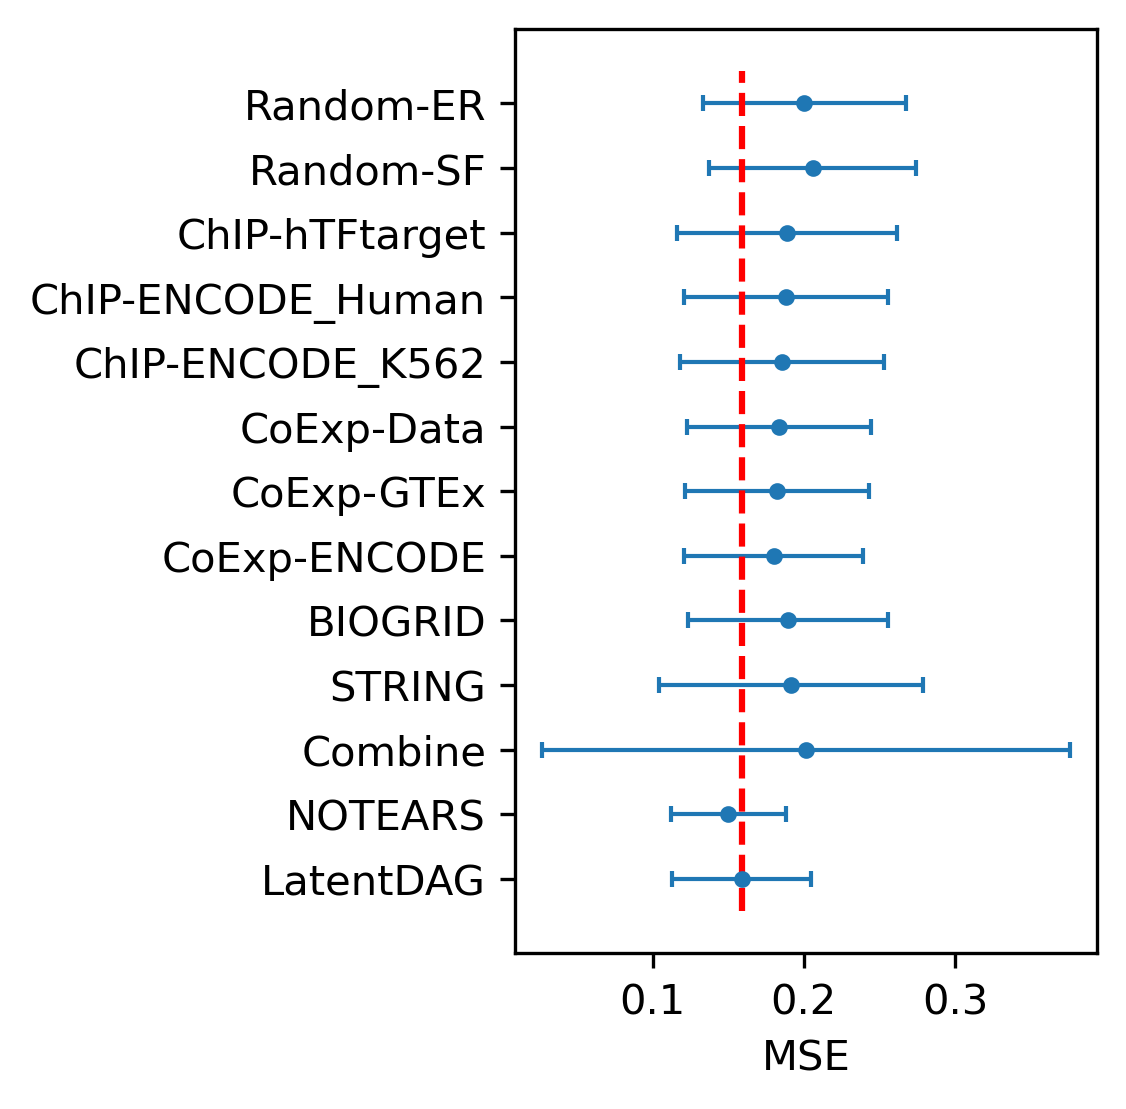

In [16]:
mean_mse = []
std_mse = []
for ii in range(13):
    mean_mse.append(loss_nw[ii,:,:].reshape(-1)[bool_nw[ii,:,:].reshape(-1)].mean())
    std_mse.append(loss_nw[ii,:,:].reshape(-1)[bool_nw[ii,:,:].reshape(-1)].std())

plt.figure(dpi=300, figsize=(2.5, 4))
(_, caps, _) = plt.errorbar(mean_mse[::-1], range(len(mean_mse)), xerr=std_mse[::-1], fmt='.', elinewidth=1, capsize=2)

for cap in caps:
    cap.set_markeredgewidth(1)

ax = plt.gca()
ax.yaxis.set_ticks(range(len(mean_mse)))
ax.yaxis.set_ticklabels(["Random-ER", "Random-SF", "ChIP-hTFtarget", "ChIP-ENCODE_Human", "ChIP-ENCODE_K562", "CoExp-Data", "CoExp-GTEx", "CoExp-ENCODE", "BIOGRID", "STRING", "Combine","NOTEARS", "LatentDAG"][::-1])
ax.set_xlabel("MSE")

ax.vlines(mean_mse[-1], -0.5, len(mean_mse)-0.5, color='red', linestyles='dashed')
plt.savefig("./figureS7_SGC_mse.pdf", dpi="figure", bbox_inches="tight")

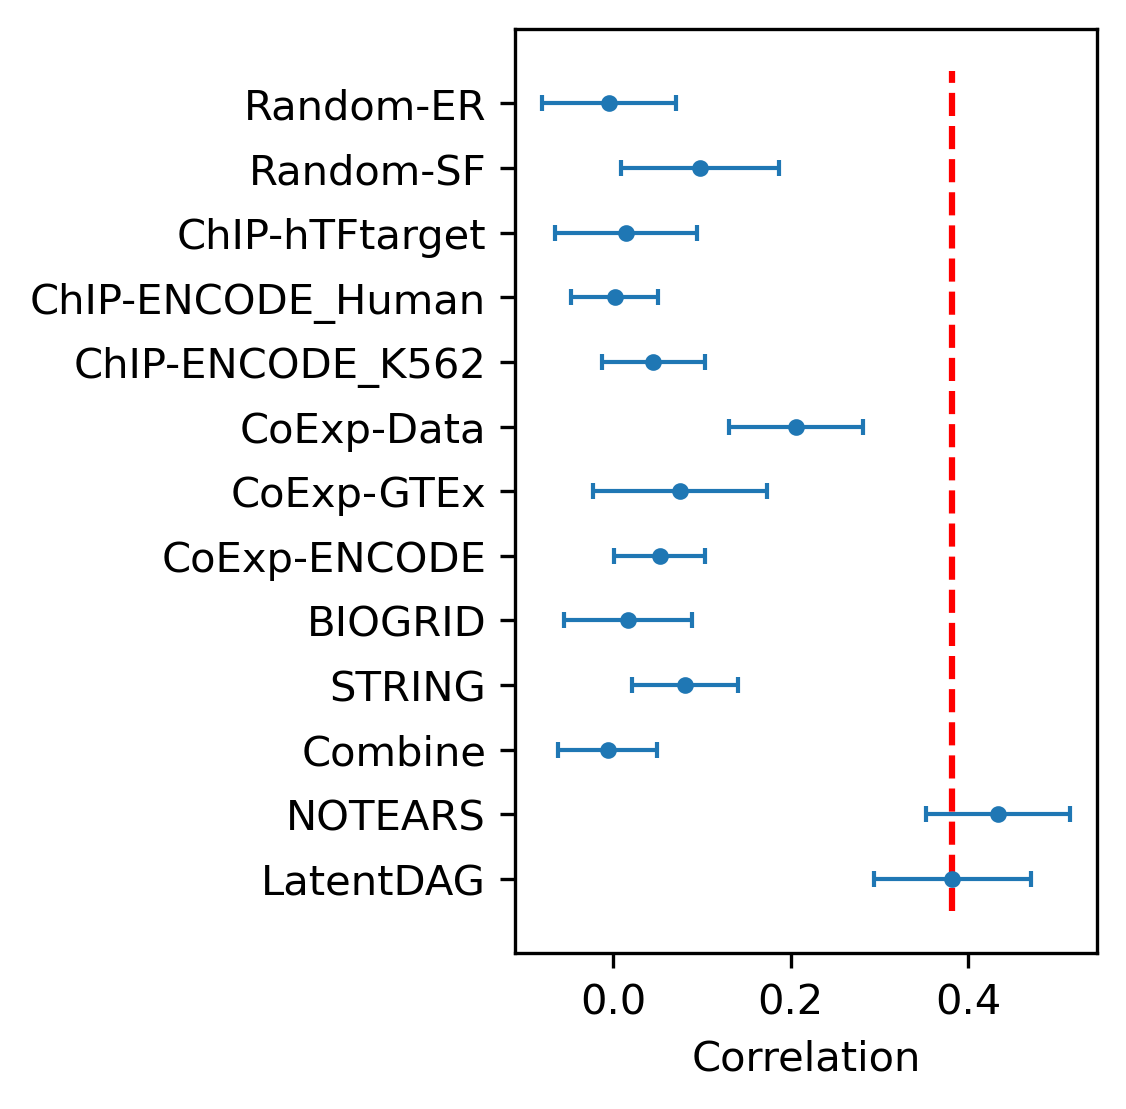

In [17]:
mean_mse = []
std_mse = []
for ii in range(13):
    mean_mse.append(p_nw[ii,:,:].reshape(-1)[bool_nw[ii,:,:].reshape(-1)].mean())
    std_mse.append(p_nw[ii,:,:].reshape(-1)[bool_nw[ii,:,:].reshape(-1)].std())

plt.figure(dpi=300, figsize=(2.5, 4))
(_, caps, _) = plt.errorbar(mean_mse[::-1], range(len(mean_mse)), xerr=std_mse[::-1], fmt='.', elinewidth=1, capsize=2)

for cap in caps:
    cap.set_markeredgewidth(1)

ax = plt.gca()
ax.yaxis.set_ticks(range(len(mean_mse)))
ax.yaxis.set_ticklabels(["Random-ER", "Random-SF", "ChIP-hTFtarget", "ChIP-ENCODE_Human", "ChIP-ENCODE_K562", "CoExp-Data", "CoExp-GTEx", "CoExp-ENCODE", "BIOGRID", "STRING", "Combine","NOTEARS", "LatentDAG"][::-1])
ax.set_xlabel("Correlation")

ax.vlines(mean_mse[-1], -0.5, len(mean_mse)-0.5, color='red', linestyles='dashed')
plt.savefig("./figureS7_SGC_p.pdf", dpi="figure", bbox_inches="tight")

### significance

In [18]:
from scipy.stats import ttest_ind
from scipy.stats import ttest_ind_from_stats

In [19]:
for ii in range(12):
    a1 = loss_nw[ii,:,:].reshape(-1)[bool_nw[ii,:,:].reshape(-1)]
    a2 = loss_nw[-1,:,:].reshape(-1)[bool_nw[-1,:,:].reshape(-1)]
    print(ttest_ind(a1, a2, equal_var=False))

Ttest_indResult(statistic=4.981170357632247, pvalue=1.5766056316166619e-06)
Ttest_indResult(statistic=5.176886631506885, pvalue=8.467351696793184e-07)
Ttest_indResult(statistic=3.419713221808353, pvalue=0.0007958312460345903)
Ttest_indResult(statistic=3.5382288387219796, pvalue=0.0005218867331381522)
Ttest_indResult(statistic=3.2112276897150944, pvalue=0.0015882710238749854)
Ttest_indResult(statistic=3.1481167606997795, pvalue=0.0019432657345926899)
Ttest_indResult(statistic=2.9189755127447876, pvalue=0.004016259367475829)
Ttest_indResult(statistic=2.721124337275864, pvalue=0.007184454004208817)
Ttest_indResult(statistic=3.632296593763405, pvalue=0.0003829465761442442)
Ttest_indResult(statistic=3.231299870152054, pvalue=0.0015340116181311108)
Ttest_indResult(statistic=2.28649965659854, pvalue=0.024203839795550006)
Ttest_indResult(statistic=-1.433784145622247, pvalue=0.15328376293474114)


In [20]:
ttest_ind_from_stats(mean1=0.16361379220214434, std1=0.061838294547170075, mean2=loss_nw[-1,:,:].reshape(-1)[bool_nw[-1,:,:].reshape(-1)].mean(), std2=loss_nw[-1,:,:].reshape(-1)[bool_nw[-1,:,:].reshape(-1)].std(), nobs1=10, nobs2=bool_nw[-1,:,:].sum(), equal_var=False)

Ttest_indResult(statistic=0.23946881505175155, pvalue=0.8155633803934438)

In [21]:
for ii in range(12):
    a1 = loss_nw[ii,:,:].reshape(-1)[bool_nw[ii,:,:].reshape(-1)]
    a2 = loss_nw[-2,:,:].reshape(-1)[bool_nw[-2,:,:].reshape(-1)]
    print(ttest_ind(a1, a2, equal_var=False))

Ttest_indResult(statistic=6.329377789195971, pvalue=2.76438072675809e-09)
Ttest_indResult(statistic=6.39024945037897, pvalue=3.732195169718363e-09)
Ttest_indResult(statistic=4.60643474357696, pvalue=8.980100268744485e-06)
Ttest_indResult(statistic=4.809758995059482, pvalue=3.6554824715467306e-06)
Ttest_indResult(statistic=4.466460734387575, pvalue=1.568815558331054e-05)
Ttest_indResult(statistic=4.488828693816493, pvalue=1.4116942466079187e-05)
Ttest_indResult(statistic=4.221098407279855, pvalue=4.2997763606911774e-05)
Ttest_indResult(statistic=4.063816126701468, pvalue=7.716459539809279e-05)
Ttest_indResult(statistic=4.884089790083083, pvalue=2.8751118870135646e-06)
Ttest_indResult(statistic=4.223179509200537, pvalue=4.541501428727579e-05)
Ttest_indResult(statistic=2.7794351483374338, pvalue=0.006477052069819488)
Ttest_indResult(statistic=0.0, pvalue=1.0)


In [22]:
ttest_ind_from_stats(mean1=0.16361379220214434, std1=0.061838294547170075, mean2=loss_nw[-2,:,:].reshape(-1)[bool_nw[-2,:,:].reshape(-1)].mean(), std2=loss_nw[-2,:,:].reshape(-1)[bool_nw[-2,:,:].reshape(-1)].std(), nobs1=10, nobs2=bool_nw[-2,:,:].sum(), equal_var=False)

Ttest_indResult(statistic=0.6770489053159802, pvalue=0.5141745478128315)

###### pearson

In [23]:
for ii in range(12):
    a1 = p_nw[ii,:,:].reshape(-1)[bool_nw[ii,:,:].reshape(-1)]
    a2 = p_nw[-1,:,:].reshape(-1)[bool_nw[-1,:,:].reshape(-1)]
    print(ttest_ind(a1, a2, equal_var=False))

Ttest_indResult(statistic=-32.68903695092763, pvalue=7.28350096524738e-80)
Ttest_indResult(statistic=-21.008064780365842, pvalue=2.1347790646560227e-48)
Ttest_indResult(statistic=-30.293290261917566, pvalue=4.035038699059557e-75)
Ttest_indResult(statistic=-37.239987300759, pvalue=6.884533302458003e-79)
Ttest_indResult(statistic=-31.440834485679822, pvalue=1.0249462707958727e-72)
Ttest_indResult(statistic=-14.786538947057918, pvalue=2.6139355017483416e-33)
Ttest_indResult(statistic=-22.31281559927126, pvalue=3.250169204435648e-53)
Ttest_indResult(statistic=-31.65930401536151, pvalue=8.802859719388553e-71)
Ttest_indResult(statistic=-31.007796482546976, pvalue=6.052633672164782e-75)
Ttest_indResult(statistic=-27.788757592887126, pvalue=9.325309780847331e-66)
Ttest_indResult(statistic=-36.6334056805417, pvalue=1.1443363944705734e-81)
Ttest_indResult(statistic=4.206695264840907, pvalue=3.9564032989906437e-05)


In [24]:
ttest_ind_from_stats(mean1=0.1612640836099545, std1=0.164969210231839, mean2=p_nw[-1,:,:].reshape(-1)[bool_nw[-1,:,:].reshape(-1)].mean(), std2=p_nw[-1,:,:].reshape(-1)[bool_nw[-1,:,:].reshape(-1)].std(), nobs1=10, nobs2=bool_nw[-1,:,:].sum(), equal_var=False)

Ttest_indResult(statistic=-4.171549884468848, pvalue=0.002126184649875599)

In [25]:
for ii in range(12):
    a1 = p_nw[ii,:,:].reshape(-1)[bool_nw[ii,:,:].reshape(-1)]
    a2 = p_nw[-2,:,:].reshape(-1)[bool_nw[-2,:,:].reshape(-1)]
    print(ttest_ind(a1, a2, equal_var=False))

Ttest_indResult(statistic=-38.53456113069722, pvalue=6.394601474814099e-92)
Ttest_indResult(statistic=-25.555858971540545, pvalue=6.474768178345135e-58)
Ttest_indResult(statistic=-35.860166334511206, pvalue=5.026317235932731e-87)
Ttest_indResult(statistic=-44.63750004476507, pvalue=5.7847343889961296e-92)
Ttest_indResult(statistic=-38.06456697993907, pvalue=1.3106994394205688e-86)
Ttest_indResult(statistic=-19.86248578904695, pvalue=4.827099479204587e-48)
Ttest_indResult(statistic=-26.805603171598882, pvalue=6.729232691401156e-63)
Ttest_indResult(statistic=-38.55133965303136, pvalue=1.7256728209959825e-84)
Ttest_indResult(statistic=-36.811271212230814, pvalue=8.690288720285549e-87)
Ttest_indResult(statistic=-34.12310098007565, pvalue=4.320389472621702e-80)
Ttest_indResult(statistic=-43.619190198411395, pvalue=5.5672033951759224e-95)
Ttest_indResult(statistic=0.0, pvalue=1.0)


In [26]:
ttest_ind_from_stats(mean1=0.1612640836099545, std1=0.164969210231839, mean2=p_nw[-2,:,:].reshape(-1)[bool_nw[-2,:,:].reshape(-1)].mean(), std2=p_nw[-2,:,:].reshape(-1)[bool_nw[-2,:,:].reshape(-1)].std(), nobs1=10, nobs2=bool_nw[-2,:,:].sum(), equal_var=False)

Ttest_indResult(statistic=-5.146992524629674, pvalue=0.0005183847203612116)